In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [2]:
data = pd.read_csv('data/custom_train_2.csv')

In [3]:
class_label = data['class'].unique()
class_label

array(['협박 대화', '기타 괴롭힘 대화', '갈취 대화', '직장 내 괴롭힘 대화', '일반 대화'],
      dtype=object)

In [4]:
from sklearn.preprocessing import LabelEncoder
y = data['label']
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [6]:
X_list = list(np.stack(data['conversation'].values))


In [7]:
X_list[6436]

'정 과장님 왜 ? 다름이 아니라 저 부모님이 아프신데 간호 할 사람이 저밖에 없어서 휴가를 써야 할 것 같습니다 . 부모님이 아프시면 간병인을 쓰면 되지 않나 . 그래서 자식이 옆에 있어야 조금이라도 도움이 될 것 같아서 그렇습니다 . 안돼 . 내가 누누이 경고했지 집안일을'

## KoBert

In [8]:
# https://github.com/SKTBrain/KoBERT/tree/master/kobert_hf

# ! pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

In [9]:
from kobert_tokenizer import KoBERTTokenizer
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


In [10]:
sample = tokenizer.encode(X_list[0])

In [11]:
tokenizer.decode(sample)

'[CLS] 지금 너 스스로를 죽여달라고 애원하는 것인가? 아닙니다. 죄송합니다. 죽을 거면 혼자 죽지 우리까지 사건에 휘말리게 해? 진짜 죽여버리고 싶게. 정말 잘못했습니다. 너가 선택해. 너가 죽을래 네 가족을 죽여줄까[SEP]'

In [12]:
total_data_text = list(X_list)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이 평균, 최대, 표준편차
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 최대 길이를 (평균 + 2.5*표준편차)
max_tokens = np.mean(num_tokens) + 0 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {100 * np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함. ')

문장길이 평균 :  143.6829292929293
문장길이 최대 :  455
문장길이 표준편차 :  70.74681112494424
pad_sequences maxlen :  143
전체 문장의 60.81818181818182%가 maxlen 설정값 이내에 포함. 


In [13]:
inputs = tokenizer(X_list,return_tensors='tf', 
                   padding=True, truncation=True,max_length=maxlen)


In [14]:
X = tf.multiply(inputs.input_ids,inputs.attention_mask)

In [15]:
X.numpy()

array([[   2, 4299, 1457, ...,    0,    0,    0],
       [   2,  517,   54, ...,    0,    0,    0],
       [   2, 1315, 5872, ...,    0,    0,    0],
       ...,
       [   2,  517, 5330, ..., 4955, 6970,    3],
       [   2, 3097, 3511, ..., 5770, 1406,    3],
       [   2, 1375, 1194, ...,    0,    0,    0]], dtype=int32)

### 데이터 분할

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.numpy(), y, test_size=0.1, random_state=42)


In [17]:
y_train

array([4, 1, 1, ..., 3, 3, 1])

In [18]:
X_train

array([[   2, 3480, 6536, ...,    0,    0,    0],
       [   2,  537, 7020, ...,    0,    0,    0],
       [   2, 3257, 5330, ...,  905, 7266,    3],
       ...,
       [   2, 1457, 5702, ..., 1698, 3493,    3],
       [   2, 1457, 5025, ...,    0,    0,    0],
       [   2, 1316, 7960, ...,    0,    0,    0]], dtype=int32)

## 모델

In [19]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()   # 부모 클래스 상속 초기화, 필수는 아님 
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            # tf.newaxis : 차원 추가, [:, tf.newaxis]은 열벡터로 변환 
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],  
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        # 차원 추가 (1, ...)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]
    
    def get_config(self):
        return {
            'position': self.pos_encoding.shape[1],
            'd_model': self.pos_encoding.shape[2],
        }

In [20]:
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    # tf.shape(key)[-1] = 워드벡터의 크기 
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    # 마스크의 1이면 큰값을 빼는 거니까 softmax를 지나면 0에 수렴 
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output


In [21]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model
        
        # 워드벡터가 헤드수로 나머지 없이 나누어 져야함
        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        # input.shape : [batch_size, seq_len, d_model(self.num_head*self.depth)]
            # seq_len : 문장길이
            # d_model : 임베딩 차원 
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        #[batch_size, self.num_head, seq_len, self.depth)]
        # transpose를 통해 num_heads를 앞으로 불러와 병렬연산 효율성(gpu활용성)을 높임 
            # 일반적으로 뒷 차원의 크기가 클 수록 효율적
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query,batch_size)
        key = self.split_heads(key,batch_size)
        value = self.split_heads(value,batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

    def get_config(self):
        return {
            'num_heads': self.num_heads,
            'd_model': self.d_model,
            'depth': self.depth,
        }

In [22]:
# 숫자가 0인 부분을 체크한 벡터를 리턴
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [23]:
# 숫자가 0인 부분도 마스킹
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    # tf.linalg.band_part: 대각요소를 가져오거나 이를 기준을 다른 것을 제거 
        # (텐서, 유지할 아래 대각요소, 유지할 위 대각요소) -1이면 전부 
        # 대각요소는 항상 유지 
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [24]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)


In [25]:
# 전체 인코더. 인코딩 레이어를 여러개 
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,),name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)


In [26]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                num_classes,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
  
    # 인코더에서 패딩을 위한 마스크
    # output_shape:mask[:, tf.newaxis, tf.newaxis, :]를 (1,1,batch_size,sequence_length)로 변경
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None), 
        name='enc_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model, 
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.GlobalAveragePooling1D()(enc_outputs)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(outputs)

    return tf.keras.Model(inputs=inputs, outputs=outputs, name=name)


In [27]:
# ! pip install wandb==0.16.0

In [28]:
import wandb

In [29]:
wandb.login(key = 'a37365b93b89624b1f639438fcc3d6c5503f21b5')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /aiffel/.netrc


True

In [30]:
# 하이퍼파라미터
# NUM_LAYERS = 4 # 인코더와 디코더의 층의 개수 
# D_MODEL = 64 # 인코더와 디코더 내부의 입/출력의 고정 차원
# UNITS = 128 # 피드 포워드 신경망의 은닉층의 크기
# DROPOUT = 0.1 # 드롭아웃의 비율

NUM_HEADS = 4 # 멀티 헤드 어텐션에서의 헤드 수 
NUM_CLASSES = len(class_label)  #레이블 수
VOCAB_SIZE = tokenizer.vocab_size #단어사전 크기
MAX_LENGTH = X.shape[1] # maxlen

# model = transformer(
#             vocab_size=VOCAB_SIZE,
#             num_layers=NUM_LAYERS,
#             units=UNITS,
#             d_model=D_MODEL,
#             num_heads=NUM_HEADS,
#             num_classes=NUM_CLASSES,
#             dropout=DROPOUT)

In [31]:
sweep_config = {
    "name": "sweep_test_nlp",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "method": "random",
    "parameters": {
        "UNITS" : {"values" : [32, 64, 128]},
        "NUM_LAYERS" : {
            "distribution": "int_uniform",
            "min" : 3,
            "max" : 6
        },
        "D_MODEL" :{"values" : [32, 64, 128]}            
                    
        }
    }

In [32]:
def train():
    default_config = {
        "VOCAB_SIZE" : VOCAB_SIZE,
        "UNITS" : 128,
        "NUM_CLASSES" : 5,
        "loss" : "sparse_categorical_crossentropy",
        "metrics" : ["accuracy"],
        "epoch" : 30,
        "batch_size" : 32,
        "NUM_LAYERS" : 4,
        "D_MODEL" : 128,
        "NUM_HEADS" : 4  
    }
    import os

    # 환경 변수 설정
    os.environ['WANDB_AGENT_DISABLE_FLAPPING'] = 'true'

    wandb.init(config = default_config)
    
    config = wandb.config
    
    model = transformer(
        vocab_size=config.VOCAB_SIZE,
        num_layers=config.NUM_LAYERS,
        units=config.UNITS,
        d_model=config.D_MODEL,
        num_heads=config.NUM_HEADS,
        num_classes=config.NUM_CLASSES,
        dropout=0.1)

    # 머신 러닝 학습때 여러가지 optimzier를 사용할 경우나 learning rate를 조절할 경우에는 아래와 같은 형태의 코드를 응용합니다.

    # Optimizer 설정 
    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
                                                       
    model.compile(optimizer = optimizer,
                  loss = config.loss,
                  metrics = config.metrics)

    # WandbCallback 함수는 후술합니다.    
    EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)
    from wandb.keras import WandbCallback

    model.fit(X_train, y_train,
              epochs = config.epoch,
              batch_size = config.batch_size,
              validation_split=0.2,
              callbacks = [EarlyStopping, WandbCallback()])
    
    
    validation_loss, validation_accuracy = model.evaluate(X_test, y_test, verbose=2)
    
    validation_loss_log = validation_loss.numpy() if isinstance(validation_loss, tf.Tensor) else validation_loss
    validation_accuracy_log = validation_accuracy.numpy() if isinstance(validation_accuracy, tf.Tensor) else validation_accuracy
  

    
    # wandb.log 함수 안에 기록하고 싶은 정보를 담습니다.
    
    wandb.log({"Validation Accuracy Rate: " : round(validation_accuracy_log * 100, 2),
               "Validation Error Rate: " : round((1 - validation_accuracy_log) * 100, 2),
               "Validation Loss" : validation_loss_log
              })


In [ ]:
# entity와 project에 본인의 아이디와 프로젝트명을 입력하세요

sweep_id = wandb.sweep(sweep_config,
                       entity = 'silpiria',
                       project = 'DLTHON1')

# run the sweep
wandb.agent(sweep_id,
            function=train,
            count=10)

Create sweep with ID: ullwpbz5
Sweep URL: https://wandb.ai/silpiria/DLTHON1/sweeps/ullwpbz5


wandb: Agent Starting Run: 99nu7qay with config:
wandb: 	D_MODEL: 128
wandb: 	NUM_LAYERS: 6
wandb: 	UNITS: 64
wandb: Currently logged in as: silpiria98 (silpiria). Use `wandb login --relogin` to force relogin


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/30
223/223 [==============================] - 17s 48ms/step - loss: 1.2972 - accuracy: 0.4162 - val_loss: 1.2273 - val_accuracy: 0.4287


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_115641-99nu7qay/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_115641-99nu7qay/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_115641-99nu7qay/files/model-best)... Done. 0.1s


Epoch 2/30
223/223 [==============================] - 9s 42ms/step - loss: 1.1731 - accuracy: 0.4797 - val_loss: 1.1252 - val_accuracy: 0.4675


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_115641-99nu7qay/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_115641-99nu7qay/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_115641-99nu7qay/files/model-best)... Done. 0.1s


Epoch 3/30
223/223 [==============================] - 9s 42ms/step - loss: 1.0405 - accuracy: 0.5664 - val_loss: 0.9294 - val_accuracy: 0.6375


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_115641-99nu7qay/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_115641-99nu7qay/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_115641-99nu7qay/files/model-best)... Done. 0.1s


Epoch 4/30
223/223 [==============================] - 9s 42ms/step - loss: 0.8466 - accuracy: 0.6647 - val_loss: 0.8037 - val_accuracy: 0.6773


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_115641-99nu7qay/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_115641-99nu7qay/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_115641-99nu7qay/files/model-best)... Done. 0.1s


Epoch 5/30
223/223 [==============================] - 9s 42ms/step - loss: 0.7362 - accuracy: 0.7135 - val_loss: 0.7988 - val_accuracy: 0.6925


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_115641-99nu7qay/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_115641-99nu7qay/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_115641-99nu7qay/files/model-best)... Done. 0.1s


Epoch 6/30
223/223 [==============================] - 9s 42ms/step - loss: 0.6608 - accuracy: 0.7457 - val_loss: 0.6842 - val_accuracy: 0.7402


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_115641-99nu7qay/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_115641-99nu7qay/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_115641-99nu7qay/files/model-best)... Done. 0.1s


Epoch 7/30
223/223 [==============================] - 9s 42ms/step - loss: 0.5982 - accuracy: 0.7712 - val_loss: 0.6845 - val_accuracy: 0.7464
Epoch 8/30
223/223 [==============================] - 10s 43ms/step - loss: 0.5558 - accuracy: 0.7912 - val_loss: 0.6689 - val_accuracy: 0.7553


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_115641-99nu7qay/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_115641-99nu7qay/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_115641-99nu7qay/files/model-best)... Done. 0.1s


Epoch 9/30
223/223 [==============================] - 9s 42ms/step - loss: 0.5157 - accuracy: 0.8103 - val_loss: 0.6422 - val_accuracy: 0.7626


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_115641-99nu7qay/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_115641-99nu7qay/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_115641-99nu7qay/files/model-best)... Done. 0.1s


Epoch 10/30
223/223 [==============================] - 9s 42ms/step - loss: 0.4913 - accuracy: 0.8159 - val_loss: 0.5901 - val_accuracy: 0.7772


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_115641-99nu7qay/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_115641-99nu7qay/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_115641-99nu7qay/files/model-best)... Done. 0.1s


Epoch 11/30
223/223 [==============================] - 9s 42ms/step - loss: 0.4736 - accuracy: 0.8251 - val_loss: 0.5805 - val_accuracy: 0.7811


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_115641-99nu7qay/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_115641-99nu7qay/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_115641-99nu7qay/files/model-best)... Done. 0.1s


Epoch 12/30
223/223 [==============================] - 9s 42ms/step - loss: 0.4340 - accuracy: 0.8392 - val_loss: 0.6889 - val_accuracy: 0.7379
Epoch 13/30
223/223 [==============================] - 9s 42ms/step - loss: 0.4137 - accuracy: 0.8479 - val_loss: 0.6001 - val_accuracy: 0.7744
Epoch 14/30
223/223 [==============================] - 9s 42ms/step - loss: 0.3947 - accuracy: 0.8544 - val_loss: 0.6155 - val_accuracy: 0.7727
31/31 - 1s - loss: 0.6164 - accuracy: 0.7838


Validation Accuracy Rate:,▁
Validation Error Rate:,▁
Validation Loss,▁
accuracy,▁▂▃▅▆▆▇▇▇▇████
epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
loss,█▇▆▅▄▃▃▂▂▂▂▁▁▁
val_accuracy,▁▂▅▆▆▇▇▇███▇██
val_loss,█▇▅▃▃▂▂▂▂▁▁▂▁▁
Validation Accuracy Rate:,78.38
Validation Error Rate:,21.62
Validation Loss,0.61644


wandb: Agent Starting Run: q6lor9ty with config:
wandb: 	D_MODEL: 64
wandb: 	NUM_LAYERS: 6
wandb: 	UNITS: 128


Epoch 1/30
223/223 [==============================] - 15s 41ms/step - loss: 1.5045 - accuracy: 0.3309 - val_loss: 1.2872 - val_accuracy: 0.3996


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best)... Done. 0.0s


Epoch 2/30
223/223 [==============================] - 8s 36ms/step - loss: 1.2325 - accuracy: 0.4314 - val_loss: 1.2243 - val_accuracy: 0.4624


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best)... Done. 0.0s


Epoch 3/30
223/223 [==============================] - 8s 36ms/step - loss: 1.1748 - accuracy: 0.4652 - val_loss: 1.1400 - val_accuracy: 0.4888


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best)... Done. 0.0s


Epoch 4/30
223/223 [==============================] - 8s 36ms/step - loss: 1.0932 - accuracy: 0.5147 - val_loss: 1.0327 - val_accuracy: 0.5376


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best)... Done. 0.0s


Epoch 5/30
223/223 [==============================] - 8s 36ms/step - loss: 0.9822 - accuracy: 0.5833 - val_loss: 0.8959 - val_accuracy: 0.6352


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best)... Done. 0.0s


Epoch 6/30
223/223 [==============================] - 8s 37ms/step - loss: 0.8918 - accuracy: 0.6251 - val_loss: 0.8529 - val_accuracy: 0.6397


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best)... Done. 0.0s


Epoch 7/30
223/223 [==============================] - 8s 36ms/step - loss: 0.8253 - accuracy: 0.6528 - val_loss: 0.8076 - val_accuracy: 0.6762


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best)... Done. 0.0s


Epoch 8/30
223/223 [==============================] - 8s 36ms/step - loss: 0.7750 - accuracy: 0.6871 - val_loss: 0.7502 - val_accuracy: 0.6930


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best)... Done. 0.0s


Epoch 9/30
223/223 [==============================] - 8s 36ms/step - loss: 0.7276 - accuracy: 0.7069 - val_loss: 0.7535 - val_accuracy: 0.6981
Epoch 10/30
223/223 [==============================] - 8s 35ms/step - loss: 0.6925 - accuracy: 0.7247 - val_loss: 0.6860 - val_accuracy: 0.7284


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best)... Done. 0.0s


Epoch 11/30
223/223 [==============================] - 8s 36ms/step - loss: 0.6600 - accuracy: 0.7406 - val_loss: 0.6775 - val_accuracy: 0.7363


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best)... Done. 0.0s


Epoch 12/30
223/223 [==============================] - 8s 36ms/step - loss: 0.6266 - accuracy: 0.7590 - val_loss: 0.6612 - val_accuracy: 0.7486


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best)... Done. 0.0s


Epoch 13/30
223/223 [==============================] - 8s 36ms/step - loss: 0.6083 - accuracy: 0.7647 - val_loss: 0.6551 - val_accuracy: 0.7508


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best)... Done. 0.0s


Epoch 14/30
223/223 [==============================] - 8s 36ms/step - loss: 0.5806 - accuracy: 0.7726 - val_loss: 0.6426 - val_accuracy: 0.7677


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best)... Done. 0.0s


Epoch 15/30
223/223 [==============================] - 8s 36ms/step - loss: 0.5601 - accuracy: 0.7837 - val_loss: 0.6125 - val_accuracy: 0.7677


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best)... Done. 0.0s


Epoch 16/30
223/223 [==============================] - 8s 36ms/step - loss: 0.5498 - accuracy: 0.7870 - val_loss: 0.6385 - val_accuracy: 0.7660
Epoch 17/30
223/223 [==============================] - 8s 36ms/step - loss: 0.5233 - accuracy: 0.8005 - val_loss: 0.5992 - val_accuracy: 0.7840


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best)... Done. 0.0s


Epoch 18/30
223/223 [==============================] - 8s 36ms/step - loss: 0.4987 - accuracy: 0.8121 - val_loss: 0.5906 - val_accuracy: 0.7823


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best)... Done. 0.0s


Epoch 19/30
223/223 [==============================] - 8s 36ms/step - loss: 0.4883 - accuracy: 0.8151 - val_loss: 0.5958 - val_accuracy: 0.7806
Epoch 20/30
223/223 [==============================] - 8s 35ms/step - loss: 0.4757 - accuracy: 0.8214 - val_loss: 0.6033 - val_accuracy: 0.7778
Epoch 21/30
223/223 [==============================] - 8s 36ms/step - loss: 0.4674 - accuracy: 0.8238 - val_loss: 0.5706 - val_accuracy: 0.7879


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dktc/wandb/run-20240626_120233-q6lor9ty/files/model-best)... Done. 0.0s


Epoch 22/30
 66/223 [=======>......................] - ETA: 5s - loss: 0.4385 - accuracy: 0.8286 ETA: 6s - loss: 0.4180 - accuracy: 0.83 - ETA: 6s

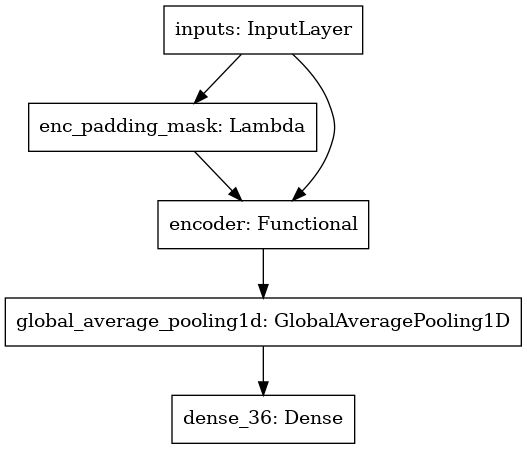

In [35]:
from tensorflow.keras.utils import plot_model
plot_model(model)

F1 score

In [36]:
from tensorflow.keras import backend as K

def f1_score(y_true, y_pred):
    # 예측값을 0과 1로 반올림
    y_pred = tf.round(y_pred)

    # True Positives, False Positives, False Negatives 계산
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))

    # Precision, Recall 계산
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())

    # F1 Score 계산
    f1_val = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
    return f1_val

In [42]:
epochs=10
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', metrics=['accuracy', f1_score])

In [43]:
from tensorflow.keras.callbacks import  ModelCheckpoint

cb = ModelCheckpoint(f'models/{NUM_LAYERS}-{D_MODEL}-{NUM_HEADS}-{UNITS}.h5',
                    save_weights_only=True, 
                    save_best_only=False,    
                    monitor='val_loss',
                    mode='min',
                    verbose=1)
EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(X_test, y_test),
                    callbacks=[EarlyStopping, cb],
                    verbose=1)

Epoch 1/10
140/140 [==============================] - 10s 42ms/step - loss: 1.0668 - accuracy: 0.5369 - f1_score: 0.5704 - val_loss: 0.5514 - val_accuracy: 0.8000 - val_f1_score: 0.8798

Epoch 00001: saving model to models/4-64-4-128.h5
Epoch 2/10
140/140 [==============================] - 5s 33ms/step - loss: 0.4551 - accuracy: 0.8371 - f1_score: 0.8751 - val_loss: 0.4440 - val_accuracy: 0.8384 - val_f1_score: 0.8988

Epoch 00002: saving model to models/4-64-4-128.h5
Epoch 3/10
140/140 [==============================] - 5s 33ms/step - loss: 0.2934 - accuracy: 0.9002 - f1_score: 0.8886 - val_loss: 0.4606 - val_accuracy: 0.8465 - val_f1_score: 0.8967

Epoch 00003: saving model to models/4-64-4-128.h5
Epoch 4/10
140/140 [==============================] - 5s 34ms/step - loss: 0.2071 - accuracy: 0.9345 - f1_score: 0.8949 - val_loss: 0.5620 - val_accuracy: 0.8333 - val_f1_score: 0.9005

Epoch 00004: saving model to models/4-64-4-128.h5
Epoch 5/10
140/140 [==============================] - 5

In [44]:
model.load_weights('models/4-64-4-128.h5')

**결과 기록**  


In [33]:
model.save_weights('models/transformer_weights.h5')

In [42]:
model.load_weights('models/transformer_weights.h5')


In [34]:
model.save('models/transformer.h5')

In [34]:
# 혼동행렬
y_pred = model.predict(X_test,batch_size=1)
y_pred_classes = np.argmax(y_pred, axis=1)

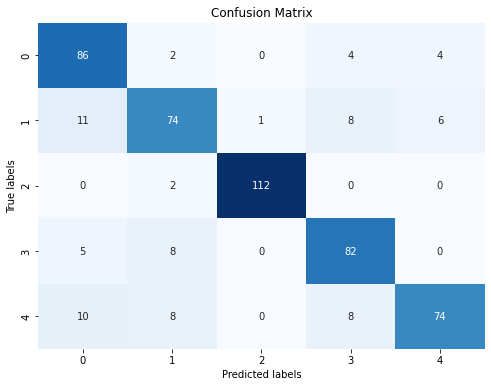

In [39]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(y_test, y_pred_classes)
# 히트맵 그리기

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=[0,1,2,3,4], yticklabels=[0,1,2,3,4])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## 불용어 제거

In [18]:
# 문맥상 진짜 의미가 없는 불용어 제거 
stopwords = ['그렇게','아','어떻게', '이렇게', '그렇군요', '있어요']
# 워드 클라우드에서 보기 편하게 일반어 제거
s = stopwords + ['내가', '다', '니','니가','넌','그냥', '너', '왜', '야','진짜',
                '나','좀', '지금', '내', '아니','우리','네','안','그','이','어',
                '그래', '그럼', '아니야', '응', '너가', '제가', '저', '거','뭐',
                '이거','여기', '저는','저도', '전', '어', '나도', '잘', '너무',
                '정말', '나는', '너도', '네가', '넌', '난', '널']

In [19]:
X_sw = data['conversation'].apply(preprocess_sentence, stopwords=s)
X_sw_list = list(np.stack(X_sw.values))


In [20]:
inputs_sw = tokenizer(X_sw_list,return_tensors='tf', 
                   padding=True, truncation=True,max_length=maxlen)


In [21]:
X_sw = tf.multiply(inputs_sw.input_ids,inputs_sw.attention_mask)

In [23]:
from sklearn.model_selection import train_test_split

X_sw_train, X_sw_test, y_sw_train, y_sw_test = train_test_split(X_sw.numpy(), y, test_size=0.1, random_state=42)


In [111]:
NUM_CLASSES = len(class_label)
VOCAB_SIZE = tokenizer.vocab_size
MAX_LENGTH = X_sw.shape[1]

# 하이퍼파라미터
NUM_LAYERS = 4 # 인코더 층의 개수 
D_MODEL = 128 # 인코더 내부의 입/출력의 고정 차원
NUM_HEADS = 4 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 256 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    num_classes=NUM_CLASSES,
    dropout=DROPOUT)

model.summary()

TypeError: Input 'y' of 'Mul' Op has type float32 that does not match type float16 of argument 'x'.

In [27]:
epochs=10
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy', metrics=['accuracy', f1_score])
history = model.fit(X_sw_train,
                    y_sw_train,
                    epochs=epochs,
                    batch_size=1,
                    validation_data=(X_sw_test, y_sw_test),
                    verbose=1)



Epoch 1/10
4545/4545 [==============================] - 45s 9ms/step - loss: 1.1662 - accuracy: 0.4931 - f1_score: 0.2532 - val_loss: 0.7803 - val_accuracy: 0.6337 - val_f1_score: 0.5960
Epoch 2/10
4545/4545 [==============================] - 41s 9ms/step - loss: 0.5793 - accuracy: 0.7780 - f1_score: 0.6814 - val_loss: 0.5257 - val_accuracy: 0.8059 - val_f1_score: 0.7386
Epoch 3/10
4545/4545 [==============================] - 41s 9ms/step - loss: 0.4021 - accuracy: 0.8475 - f1_score: 0.7509 - val_loss: 0.4951 - val_accuracy: 0.8337 - val_f1_score: 0.7604
Epoch 4/10
4545/4545 [==============================] - 41s 9ms/step - loss: 0.3137 - accuracy: 0.8865 - f1_score: 0.7760 - val_loss: 0.4582 - val_accuracy: 0.8416 - val_f1_score: 0.7762
Epoch 5/10
4545/4545 [==============================] - 41s 9ms/step - loss: 0.2454 - accuracy: 0.9140 - f1_score: 0.7872 - val_loss: 0.5471 - val_accuracy: 0.8218 - val_f1_score: 0.7861
Epoch 6/10
4545/4545 [==============================] - 41s 9ms/s

#### 결과
Epoch 10/10
4545/4545 [==============================] - 42s 9ms/step - loss: 0.0847 - accuracy: 0.9734 - f1_score: 0.8024 - val_loss: 0.6752 - val_accuracy: 0.8515 - val_f1_score: 0.8059

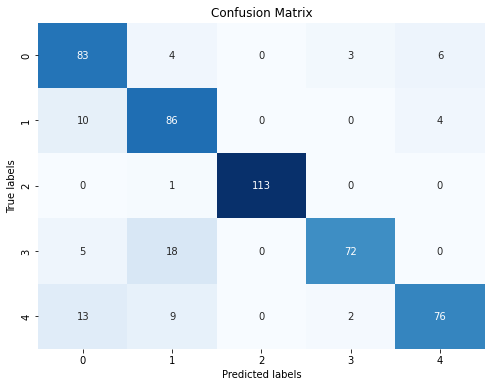

In [29]:
# 혼동행렬
y_sw_pred = model.predict(X_sw_test,batch_size=1)
y_sw_pred_classes = np.argmax(y_sw_pred, axis=1)

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(y_sw_test, y_sw_pred_classes)
# 히트맵 그리기

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=[0,1,2,3,4], yticklabels=[0,1,2,3,4])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [87]:
history.history['val_accuracy']

[0.6336633563041687,
 0.805940568447113,
 0.8336633443832397,
 0.8415841460227966,
 0.8217821717262268,
 0.8475247621536255,
 0.8475247621536255,
 0.8633663654327393,
 0.8455445766448975,
 0.8514851331710815]

# test submit

In [45]:
test = pd.read_csv('data/custom_test.csv')

In [46]:
test['conversation'][29]

'선생님도 환자타는 징크스 있겠네요 난 그런거 없어 특이하네요 다들 하나씩 있으시던데 굳이 있다면 족보에도 나와있는 전통적인 징크스 그정도 그게 뭔데요 후배가 산 과자나 음식을 하나라도 먹는다면 어떻게 되는데요 하늘에서 환자가 우수수수수 내려 아 큰일났다 왜왜 내가 지금 먹는 아이스크림 누가 산거야 제 제가 빨리 계좌번호 불러 빨리 돈 보내줄게'

In [52]:
import re
def preprocess_sentence(sentence, stopwords=None):
    # 개행자 삭제
    sentence = re.sub(r'[\n\r]', ' ', sentence)
    
    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듭니다. 
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # (a-z, A-Z,가-힣,0-9, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r"[^a-zA-Z가-힣0-9\.\?\!,]", " ", sentence)
    sentence = sentence.strip()

    # '키키'와 같이 연속된 키를 제거합니다.
    sentence = re.sub(r'키{2,}', '', sentence)
    sentence = re.sub(r'\b키\b', '', sentence)

    if stopwords:
        words = sentence.split()
        filtered_words = [word for word in words if word not in stopwords]
        sentence = ' '.join(filtered_words)

    return sentence

In [53]:
test_X = test['conversation'].apply(preprocess_sentence)
test_X_list = list(np.stack(test_X.values))


In [54]:
inputs_test = tokenizer(test_X_list,return_tensors='tf', 
                   padding=True, truncation=True,max_length=maxlen)

In [55]:
test_X = tf.multiply(inputs_test.input_ids,inputs_test.attention_mask)

In [56]:
pred = model.predict(test_X, batch_size=64)

In [57]:
np.save('transformer_predictions.npy', pred)

In [58]:
predicted_classes = np.argmax(pred, axis=1)


서브미션 파일

In [60]:
sub = pd.read_csv("data/new_submission.csv")

In [61]:
sub['class']=predicted_classes

In [62]:
sub.to_csv('data/sub.csv')